# Description
### This notebook is designed to show uses of formal_tests.py, a script designed to present some robust information regarding the barotropic model. For example, understanding the required number of ensemble members to sample the forcing, and finding the zonally symmetric climatological variance caused by the forcing.

### 1.1 Import packages

In [1]:
%matplotlib notebook
from forced_barotropic_sphere.sphere import Sphere
from forced_barotropic_sphere.solver import Solver
from forced_barotropic_sphere.forcing import Forcing
import forced_barotropic_sphere.formal_tests as ft
#import bm_methods.bm_methods
import xarray as xr
import forced_barotropic_sphere.plotting as plotters
import forced_barotropic_sphere.ensemble_methods as ensemble_methods
import numpy as np
import random
import matplotlib.pyplot as plt    
import matplotlib.animation as manim
import matplotlib.ticker as mticker
from IPython.display import display, clear_output, HTML, FileLink  # Some technical stuff, used to display animation
#from ipywidgets import FloatProgress
from ipykernel.pylab.backend_inline import flush_figures
import cartopy                   # Map projection stuff
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scipy.ndimage import gaussian_filter1d as gf1d

d2s=86400

/home/bertossa/miniconda3/envs/jupyter/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 1.1 Check how many members are needed to sample forcing well
### Here we run just the red noise forcing out to 10 years to represent the climatological spread. Then, an ensemble of size e, of the forcing equation is generated for a single timestep. The variance of the ensemble represents the ability for an ensemble of size e to produce the climatological spread at any given time. This is repeated for a couple hundred runs to capture the spread of the estimated variance. Results for a single coordinate are plotted below; i've picked the a location that aligns with our stirring latitude. Small ensembles initially underestimate the climatological variance, but quickly asymptote to the climatology value. As the ensemble size increases, the spread in the estimated variance decreases as well. 200 seems like a pretty good number?

In [2]:
dt = 4000 #time between integration steps (seconds)
nlat=64; nlon=128

fcli,fens,n_ens=ft.ensemble_forcing_sampling(nlat,nlon,dt)

15it [10:19, 41.30s/it]


<IPython.core.display.Javascript object>


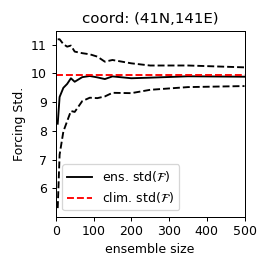

In [14]:
fig,axs = plt.subplots(1,1,figsize=(3,3))

clim = fcli.std(axis=0).mean(axis=-1)
yy,xx=17,50
fensp= fens[:,:,yy,xx]

x=n_ens
mu = np.array([ fensp[:,n].mean() for n in range(len(x)) ])
sig =np.array([ fensp[:,n].std() for n in range(len(x)) ])
axs.plot(x, gf1d(mu, sigma=0.01), color = 'k', label = 'ens. std($\mathcal{F}$)')
axs.plot(x, gf1d(mu+sig, sigma=0.01), color = 'k',linestyle='--')
axs.plot(x, gf1d(mu-sig, sigma=0.01), color = 'k',linestyle='--')
axs.axhline(clim[yy] ,linestyle='--',color='r', label = 'clim. std($\mathcal{F}$)')

axs.set_xlabel('ensemble size')
axs.set_ylabel('Forcing Std.')

axs.set_title('coord: ({:.0f}N,{:.0f}E)'.format(np.linspace(90,-90,nlat)[yy],(360./nlon*np.arange(nlon))[xx]))
axs.set_xlim(0.,max(n_ens))
# ss= np.empty((len(x),fens.shape[2]))
# for i,n in enumerate(x):
#     ss[i]=fens[:n,:-1,:,:].std(axis=0).mean(axis=(0,-1))
    
# cf= axs[1].pcolormesh(range(nlat),x, abs(clim-ss)/clim*100., vmax=10)

# plt.colorbar(cf,ax=axs[1])
plt.legend()
plt.tight_layout()
plt.show()

## 1.2 Derive Climatological Spread
### I found that running one very long climatology produced relatively large zonal variation in mean variance. It was slightly more efficient to run an ensemble (100) of 5 year simulations and average the runs to find the mean variance (I think due to the relatively long memory of the eddies, it takes a while to kill off preferential spatial features?). This also gives us a way to estimate the variance of the mean variance, which can help with formally justifying when an ensemble approaches the climatology. 

integrating for  1825.0  days, with a dt of  0.046296296296296294  days


100%|██████████████████████████████████████| 100/100 [3:40:04<00:00, 132.04s/it]


<IPython.core.display.Javascript object>


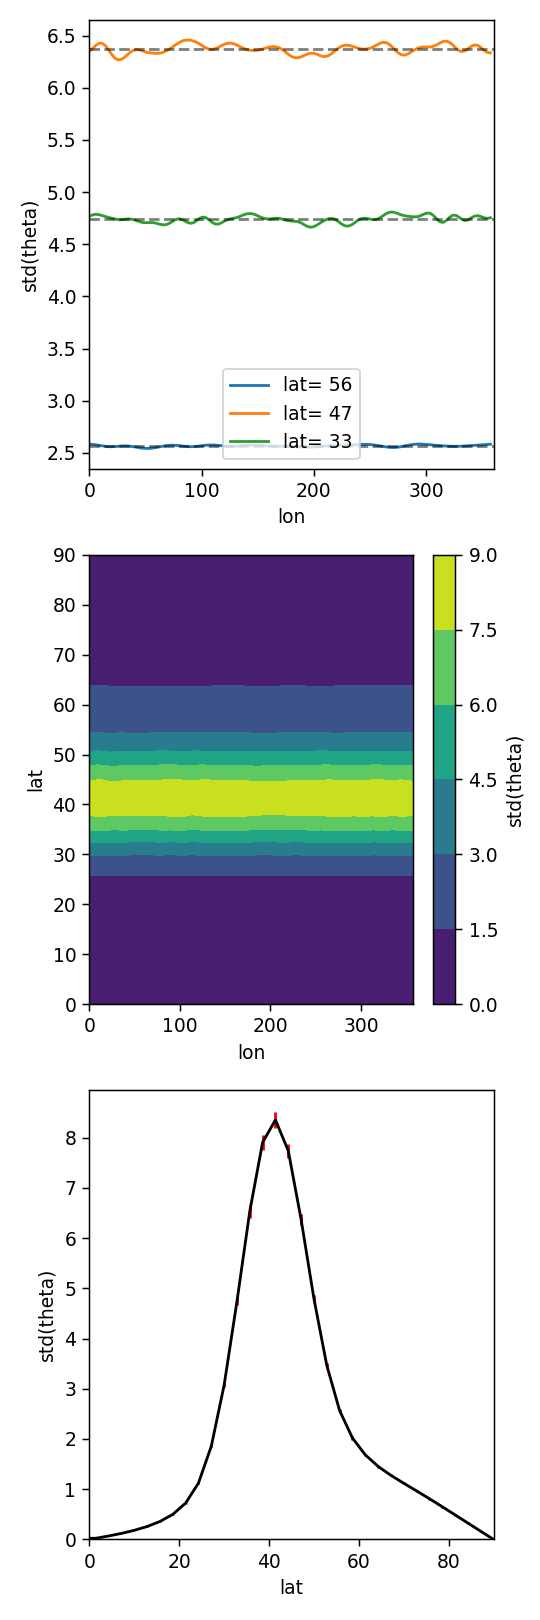

In [2]:
dt = 4000 #time between integration steps (seconds)
nlat=64; nlon=128

clim= ft.climatological_spread(nlat,nlon,dt,A=5e-12,produce_plots=True)

In [3]:
clim.to_netcdf('../climatology.nc')

## 1.3 Check to see how long it takes for ensemble to approach climatology
### Using our derived climatology from 1.2, and an ensemble of size 200, lets run a 6-week long simulation and see how our ensemble behaves.

In [15]:
num_members= 200 #num of members in the ensemble
dt = 4000 #time between integration steps (seconds)
T= d2s*6*7 #total integration time
nlat=64; nlon=128

ofreq=3

thetap = np.zeros((nlat,nlon))
vortp = np.zeros((nlat,nlon))

ics = np.array([vortp,thetap])


ensemble = ensemble_methods.integrate_ensemble(nlat,nlon,dt=dt, T=T, ofreq=ofreq, ics=ics,
                                               forcing_type='red_eddy', n_ens=num_members, temp_linear=True,
                                               vort_linear=True, vortpert=0.)

clims= xr.open_dataset('../climatology.nc')#.mean('x')


100%|█████████████████████████████████████████| 200/200 [08:50<00:00,  2.65s/it]


<IPython.core.display.Javascript object>


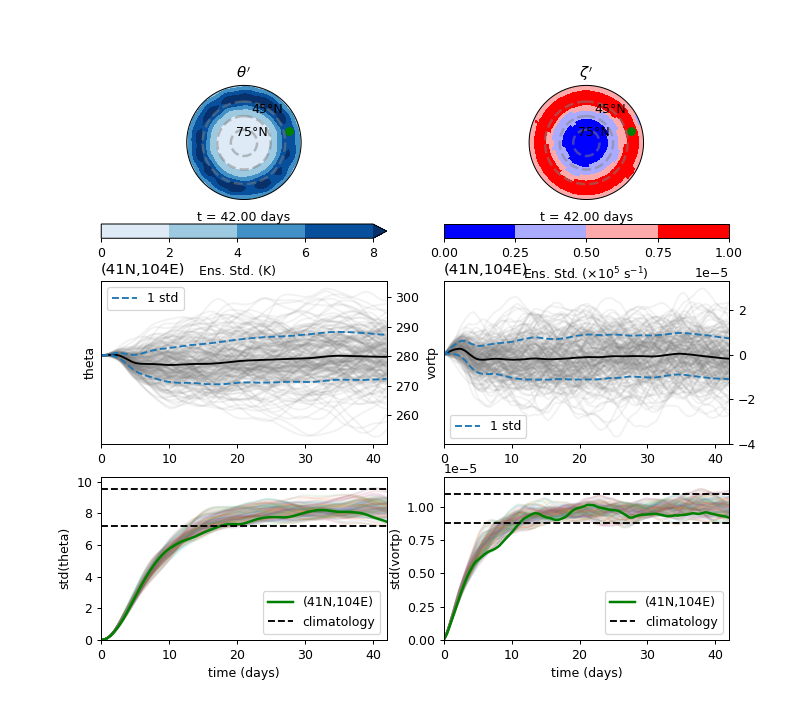

In [30]:
tidx=ensemble.time.size-1

s2d = 1/60./60./24.
fig = plt.figure(figsize=(9,8))
proj=ccrs.NorthPolarStereo()
xy=(105,40)

levels = [np.linspace(0,8,5), np.linspace(0,10,5)*0.1]

VOI = ['theta','vortp'] #variables of interest

for i,var in enumerate(VOI):
    ax1 = plt.subplot(3,len(VOI),i+1, projection = proj) #axes for map
    ax2 = plt.subplot(3,len(VOI),i+3)
    ax3 = plt.subplot(3,len(VOI),i+5) #axes for discrete point
    
    
    #plot 1
    if i==0:
        plotters.plot_theta_ensspread(ensemble.isel(time=tidx), ax=ax1, levels=levels[i])
    else:
        plotters.plot_zeta_ensspread(ensemble.isel(time=tidx), ax=ax1, levels=levels[i])
    
    ax1.scatter(x=xy[0], y=xy[1], color='g', transform = ccrs.PlateCarree())
    
    
    ens_point = ensemble[var].sel(x=xy[0], y=xy[1], method='nearest')
    
    #plot 2
    #ax2.set_title()
    ax2.set_title('({:.0f}N,{:.0f}E)'.format(float(ens_point.y),float(ens_point.x)),loc='left')
    ax2.plot(ensemble.time*s2d, ens_point.T, color='grey', alpha=0.1)
    ax2.plot(ensemble.time*s2d, ens_point.mean('ens_mem'), color='k')
    ax2.plot(ensemble.time*s2d, ens_point.mean('ens_mem') +ens_point.std('ens_mem'),
             color='tab:blue',linestyle='--')
    ax2.plot(ensemble.time*s2d, ens_point.mean('ens_mem') -ens_point.std('ens_mem'),
             color='tab:blue',linestyle='--', label = '1 std')
    
    #plot 3
    ax3.plot(ensemble.time*s2d,ensemble[var].sel(y=xy[1], method='nearest').std('ens_mem'), alpha=0.1)
    ax3.plot(ensemble.time*s2d, ens_point.std('ens_mem'),label='({:.0f}N,{:.0f}E)'.format(float(ens_point.y),float(ens_point.x)), color='g',linewidth=2)
    
    ax3.axhline(clims[var].sel(y=xy[1], method='nearest').mean(['x','runs']).values + 2*clims[var].sel(y=xy[1], method='nearest').std(['x','runs']).values,
                0,1, color = 'k', linestyle = '--', 
               label='climatology')
    ax3.axhline(clims[var].sel(y=xy[1], method='nearest').mean(['x','runs']).values - 2*clims[var].sel(y=xy[1], method='nearest').std(['x','runs']).values,
                0,1, color = 'k', linestyle = '--')


    ax2.yaxis.tick_right()
    ax3.set_xlabel('time (days)')
    ax3.set_ylabel("std({})".format(var))
    ax2.set_ylabel(var)
    ax2.set_xlim(0.,T*s2d)
    ax3.set_ylim(0.,clims[var].sel(y=xy[1], method='nearest').max(['x','runs']).values)
    ax3.set_xlim(0.,T*s2d)
    ax3.legend()
    ax2.legend()
    
plt.show()


### Above i've plotted the ensemble evolution for a single coordinate (second row). Spread is pretty large, but not too far off reality? Again, this is where we'd expect maximum stirring so having a std of ~8-9 K after 3 weeks seems reasonable if these represent atmospheric values.  The third row shows how every x-point at this latitude evolves in its ensemble std. +- 2 stds from the climatological mean are plotted with dashed lines. We see after about 3 weeks, most of the lons are within the bounds. Not exactly sure how to address those cases where some locations re-exit the climatological spread (see, for example, ~day 38 in vortp). Just need to integrate for longer?